In [1]:
DATASET_DIR = ''
#GLOVE_DIR = './glove.6B/'
SAVE_DIR = './'

import os
import pandas as pd
import keras
from keras.callbacks import EarlyStopping


environment='L'


/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


In [2]:

if environment == 'S':
    os.environ["CUDA_VISIBLE_DEVICES"] = '1'  
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth =\
        True
    sess = tf.Session(config=config)
    keras.backend.set_session(sess)
elif environment == 'L':
    os.chdir("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source")

In [25]:


X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.csv'), encoding='ISO-8859-1')
#X = (X[(X["essay_set"] == 1) | (X["essay_set"] == 2)])
X = (X[(X["essay_set"] == 1)])
y = X['domain1_score_copy']
X = X.dropna(axis=1)
X = X.drop(columns=['rater1_domain1', 'rater2_domain1'])
os.chdir("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source")


Preprocessing the Data
We will preprocess all essays and convert them to feature vectors so that they can be fed into the RNN.

These are all helper functions used to clean the essays.

In [26]:
minimum_scores = [-1, 2, 1, 0, 0, 0, 0, 0, 0]
maximum_scores = [-1, 12, 6, 3, 3, 4, 4, 30, 60]

import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            num_words += 1
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs


Defining the model
Here we define a 2-Layer LSTM Model.

Note that instead of using sigmoid activation in the output layer we will use Relu since we are not normalising training labels.



In [30]:

from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K
from keras.utils.np_utils import to_categorical


def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    #model.add(Dense(12, activation='softmax'))
    model.add(Dense(12, activation='sigmoid'))
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model
'''
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model
'''

'\nfrom keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten\nfrom keras.models import Sequential, load_model, model_from_config\nimport keras.backend as K\n\ndef get_model():\n    """Define the model."""\n    model = Sequential()\n    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))\n    model.add(LSTM(64, recurrent_dropout=0.4))\n    model.add(Dropout(0.5))\n    model.add(Dense(1, activation=\'relu\'))\n\n    model.compile(loss=\'mean_squared_error\', optimizer=\'rmsprop\', metrics=[\'mae\'])\n    model.summary()\n\n    return model\n'

Training Phase
Now we train the model on the dataset.

We will use 5-Fold Cross Validation and measure the Quadratic Weighted Kappa for each fold. We will then calculate Average Kappa for all the folds.


--------Fold 1--------



Training Word2Vec Model...


/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dense_9 (Dense)              (None, 12)                780       
Total params: 815,420
Trainable params: 815,420
Non-trainable params: 0
_________________________________________________________________


Train on 1426 samples, validate on 200 samples
Epoch 1/50


  64/1426 [>.............................] - ETA: 2:07 - loss: 0.6932 - acc: 0.4909

 192/1426 [===>..........................] - ETA: 39s - loss: 0.6909 - acc: 0.7747 

 320/1426 [=====>........................] - ETA: 21s - loss: 0.6884 - acc: 0.8315

 448/1426 [========>.....................] - ETA: 13s - loss: 0.6856 - acc: 0.8558

 576/1426 [===========>..................] - ETA: 9s - loss: 0.6821 - acc: 0.8694 

 640/1426 [============>.................] - ETA: 7s - loss: 0.6802 - acc: 0.8741

 704/1426 [=============>................] - ETA: 6s - loss: 0.6782 - acc: 0.8780

 768/1426 [===============>..............] - ETA: 5s - loss: 0.6759 - acc: 0.8812

 896/1426 [=================>............] - ETA: 3s - loss: 0.6708 - acc: 0.8863

1024/1426 [====================>.........] - ETA: 2s - loss: 0.6649 - acc: 0.8901

1152/1426 [=======================>......] - ETA: 1s - loss: 0.6579 - acc: 0.8930

1280/1426 [=========================>....] - ETA: 0s - loss: 0.6500 - acc: 0.8954

1408/1426 [============================>.] - ETA: 0s - loss: 0.6411 - acc: 0.8973

1426/1426 [==============================] - 8s 6ms/step - loss: 0.6397 - acc: 0.8976 - val_loss: 0.5111 - val_acc: 0.9167


Epoch 2/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.5122 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.4941 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.4783 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.4625 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.4443 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.4293 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.4149 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.4008 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.3881 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.3767 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.3667 - acc: 0.9167

1426/1426 [==============================] - 1s 551us/step - loss: 0.3608 - acc: 0.9167 - val_loss: 0.2581 - val_acc: 0.9167


Epoch 3/50


  64/1426 [>.............................] - ETA: 1s - loss: 0.2598 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2552 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2510 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2478 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2452 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2446 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2422 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2408 - acc: 0.9167

1024/1426 [====================>.........] - ETA: 0s - loss: 0.2394 - acc: 0.9167

1152/1426 [=======================>......] - ETA: 0s - loss: 0.2393 - acc: 0.9167

1280/1426 [=========================>....] - ETA: 0s - loss: 0.2381 - acc: 0.9167

1408/1426 [============================>.] - ETA: 0s - loss: 0.2360 - acc: 0.9167

1426/1426 [==============================] - 1s 692us/step - loss: 0.2364 - acc: 0.9167 - val_loss: 0.2283 - val_acc: 0.9167


Epoch 4/50


  64/1426 [>.............................] - ETA: 1s - loss: 0.2192 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2159 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2171 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2186 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2192 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2210 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2220 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2222 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2226 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2238 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2225 - acc: 0.9167

1426/1426 [==============================] - 1s 614us/step - loss: 0.2219 - acc: 0.9167 - val_loss: 0.2249 - val_acc: 0.9167


Epoch 5/50


  64/1426 [>.............................] - ETA: 1s - loss: 0.2136 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2071 - acc: 0.9167

 256/1426 [====>.........................] - ETA: 0s - loss: 0.2151 - acc: 0.9167

 384/1426 [=======>......................] - ETA: 0s - loss: 0.2167 - acc: 0.9167

 512/1426 [=========>....................] - ETA: 0s - loss: 0.2164 - acc: 0.9167

 640/1426 [============>.................] - ETA: 0s - loss: 0.2191 - acc: 0.9167

 768/1426 [===============>..............] - ETA: 0s - loss: 0.2198 - acc: 0.9167

 896/1426 [=================>............] - ETA: 0s - loss: 0.2204 - acc: 0.9167

1024/1426 [====================>.........] - ETA: 0s - loss: 0.2206 - acc: 0.9167

1152/1426 [=======================>......] - ETA: 0s - loss: 0.2197 - acc: 0.9167

1280/1426 [=========================>....] - ETA: 0s - loss: 0.2200 - acc: 0.9167

1408/1426 [============================>.] - ETA: 0s - loss: 0.2201 - acc: 0.9167

1426/1426 [==============================] - 1s 697us/step - loss: 0.2199 - acc: 0.9167 - val_loss: 0.2240 - val_acc: 0.9167


Epoch 6/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2115 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2111 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2152 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2201 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2219 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2210 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2207 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2188 - acc: 0.9167

1024/1426 [====================>.........] - ETA: 0s - loss: 0.2194 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2187 - acc: 0.9167

1152/1426 [=======================>......] - ETA: 0s - loss: 0.2192 - acc: 0.9167

1280/1426 [=========================>....] - ETA: 0s - loss: 0.2188 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2189 - acc: 0.9167

1408/1426 [============================>.] - ETA: 0s - loss: 0.2190 - acc: 0.9167

1426/1426 [==============================] - 1s 714us/step - loss: 0.2190 - acc: 0.9167 - val_loss: 0.2239 - val_acc: 0.9167


Epoch 7/50


  64/1426 [>.............................] - ETA: 1s - loss: 0.2231 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2187 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2220 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2148 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2159 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2144 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2167 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2159 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2163 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2182 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2191 - acc: 0.9167

1426/1426 [==============================] - 1s 601us/step - loss: 0.2188 - acc: 0.9167 - val_loss: 0.2239 - val_acc: 0.9167


Epoch 8/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2143 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2260 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2173 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2168 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2167 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2154 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2184 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2197 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2200 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2195 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2189 - acc: 0.9167

1426/1426 [==============================] - 1s 507us/step - loss: 0.2187 - acc: 0.9167 - val_loss: 0.2234 - val_acc: 0.9167


Epoch 9/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2241 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2215 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2167 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2190 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2172 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2194 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2190 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2188 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2186 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2179 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2185 - acc: 0.9167

1426/1426 [==============================] - 1s 507us/step - loss: 0.2186 - acc: 0.9167 - val_loss: 0.2239 - val_acc: 0.9167


Epoch 10/50


  64/1426 [>.............................] - ETA: 1s - loss: 0.2158 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2128 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2080 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2163 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2190 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2181 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2180 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2165 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2172 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2176 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2176 - acc: 0.9167

1426/1426 [==============================] - 1s 505us/step - loss: 0.2185 - acc: 0.9167 - val_loss: 0.2232 - val_acc: 0.9167


Epoch 11/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2170 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2182 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2169 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2155 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2155 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2156 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2174 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2168 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2176 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2178 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2187 - acc: 0.9167

1426/1426 [==============================] - 1s 494us/step - loss: 0.2183 - acc: 0.9167 - val_loss: 0.2235 - val_acc: 0.9167


Epoch 12/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2045 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2119 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2094 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2134 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2129 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2144 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2156 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2176 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2187 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2187 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2183 - acc: 0.9167

1426/1426 [==============================] - 1s 500us/step - loss: 0.2183 - acc: 0.9167 - val_loss: 0.2239 - val_acc: 0.9167


Epoch 13/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2335 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2215 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2160 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2144 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2139 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2158 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2168 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2170 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2175 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2179 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2178 - acc: 0.9167

1426/1426 [==============================] - 1s 521us/step - loss: 0.2184 - acc: 0.9167 - val_loss: 0.2237 - val_acc: 0.9167


Epoch 14/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2094 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2184 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2181 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2152 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2189 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2173 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2167 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2157 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2167 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2175 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2179 - acc: 0.9167

1426/1426 [==============================] - 1s 504us/step - loss: 0.2181 - acc: 0.9167 - val_loss: 0.2234 - val_acc: 0.9167


Epoch 15/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2088 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2161 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2142 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2164 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2187 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2194 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2195 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2179 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2179 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2170 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2179 - acc: 0.9167

1426/1426 [==============================] - 1s 499us/step - loss: 0.2182 - acc: 0.9167 - val_loss: 0.2231 - val_acc: 0.9167


Epoch 16/50


  64/1426 [>.............................] - ETA: 1s - loss: 0.2203 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2200 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2186 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2184 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2210 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2211 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2203 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2210 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2210 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2201 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2189 - acc: 0.9167

1426/1426 [==============================] - 1s 500us/step - loss: 0.2183 - acc: 0.9167 - val_loss: 0.2232 - val_acc: 0.9167


Epoch 17/50


  64/1426 [>.............................] - ETA: 1s - loss: 0.2398 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2151 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2108 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2114 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2104 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2141 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2164 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2168 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2173 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2179 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2179 - acc: 0.9167

1426/1426 [==============================] - 1s 508us/step - loss: 0.2183 - acc: 0.9167 - val_loss: 0.2235 - val_acc: 0.9167


Epoch 18/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2249 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2140 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2199 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2205 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2190 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2193 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2189 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2183 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2185 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2184 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2186 - acc: 0.9167

1426/1426 [==============================] - 1s 495us/step - loss: 0.2183 - acc: 0.9167 - val_loss: 0.2234 - val_acc: 0.9167


Epoch 19/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.1898 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2167 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2221 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2195 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2192 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2188 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2170 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2172 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2161 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2172 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2170 - acc: 0.9167

1426/1426 [==============================] - 1s 500us/step - loss: 0.2180 - acc: 0.9167 - val_loss: 0.2232 - val_acc: 0.9167


Epoch 20/50


  64/1426 [>.............................] - ETA: 1s - loss: 0.2198 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2189 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2143 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2130 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2153 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2151 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2152 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2167 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2176 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2179 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2175 - acc: 0.9167

1426/1426 [==============================] - 1s 502us/step - loss: 0.2180 - acc: 0.9167 - val_loss: 0.2235 - val_acc: 0.9167


Epoch 21/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2218 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2177 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2155 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2162 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2187 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2176 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2173 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2171 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2178 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2179 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2187 - acc: 0.9167

1426/1426 [==============================] - 1s 513us/step - loss: 0.2179 - acc: 0.9167 - val_loss: 0.2229 - val_acc: 0.9167


Epoch 22/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2192 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2081 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2110 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2176 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2189 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2195 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2202 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2192 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2167 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2178 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2180 - acc: 0.9167

1426/1426 [==============================] - 1s 508us/step - loss: 0.2178 - acc: 0.9167 - val_loss: 0.2231 - val_acc: 0.9167


Epoch 23/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2248 - acc: 0.9167

 128/1426 [=>............................] - ETA: 0s - loss: 0.2221 - acc: 0.9167

 256/1426 [====>.........................] - ETA: 0s - loss: 0.2180 - acc: 0.9167

 384/1426 [=======>......................] - ETA: 0s - loss: 0.2171 - acc: 0.9167

 512/1426 [=========>....................] - ETA: 0s - loss: 0.2154 - acc: 0.9167

 640/1426 [============>.................] - ETA: 0s - loss: 0.2159 - acc: 0.9167

 768/1426 [===============>..............] - ETA: 0s - loss: 0.2188 - acc: 0.9167

 896/1426 [=================>............] - ETA: 0s - loss: 0.2199 - acc: 0.9167

1024/1426 [====================>.........] - ETA: 0s - loss: 0.2184 - acc: 0.9167

1152/1426 [=======================>......] - ETA: 0s - loss: 0.2175 - acc: 0.9167

1280/1426 [=========================>....] - ETA: 0s - loss: 0.2170 - acc: 0.9167

1408/1426 [============================>.] - ETA: 0s - loss: 0.2179 - acc: 0.9167

1426/1426 [==============================] - 1s 589us/step - loss: 0.2178 - acc: 0.9167 - val_loss: 0.2228 - val_acc: 0.9167


Epoch 24/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2121 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2191 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2175 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2189 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2162 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2154 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2161 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2178 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2180 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2179 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2175 - acc: 0.9167

1426/1426 [==============================] - 1s 522us/step - loss: 0.2176 - acc: 0.9167 - val_loss: 0.2226 - val_acc: 0.9167


Epoch 25/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2400 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2317 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2274 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2228 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2199 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2208 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2196 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2189 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2192 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2186 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2184 - acc: 0.9167

1426/1426 [==============================] - 1s 505us/step - loss: 0.2177 - acc: 0.9167 - val_loss: 0.2221 - val_acc: 0.9167


Epoch 26/50


  64/1426 [>.............................] - ETA: 1s - loss: 0.2091 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2139 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2153 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2196 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2220 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2211 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2199 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2188 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2179 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2175 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2179 - acc: 0.9167

1426/1426 [==============================] - 1s 598us/step - loss: 0.2173 - acc: 0.9167 - val_loss: 0.2224 - val_acc: 0.9167


Epoch 27/50


  64/1426 [>.............................] - ETA: 1s - loss: 0.2107 - acc: 0.9167

 128/1426 [=>............................] - ETA: 1s - loss: 0.2105 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 1s - loss: 0.2141 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2179 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2182 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2182 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2178 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2199 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2192 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2176 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2179 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2171 - acc: 0.9167

1426/1426 [==============================] - 1s 590us/step - loss: 0.2171 - acc: 0.9167 - val_loss: 0.2219 - val_acc: 0.9167


Epoch 28/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2144 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2182 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2149 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2154 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2168 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2170 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2182 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2181 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2181 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2175 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2168 - acc: 0.9167

1426/1426 [==============================] - 1s 516us/step - loss: 0.2168 - acc: 0.9167 - val_loss: 0.2211 - val_acc: 0.9167


Epoch 29/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2187 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2167 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2148 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2185 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2148 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2150 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2147 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2154 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2153 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2165 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2164 - acc: 0.9167

1426/1426 [==============================] - 1s 523us/step - loss: 0.2166 - acc: 0.9167 - val_loss: 0.2212 - val_acc: 0.9167


Epoch 30/50


  64/1426 [>.............................] - ETA: 1s - loss: 0.2100 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2066 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2129 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2132 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2110 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2124 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2136 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2147 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2161 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2161 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2160 - acc: 0.9167

1426/1426 [==============================] - 1s 534us/step - loss: 0.2158 - acc: 0.9167 - val_loss: 0.2200 - val_acc: 0.9167


Epoch 31/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2083 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2095 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2093 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2112 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2124 - acc: 0.9168

 704/1426 [=============>................] - ETA: 0s - loss: 0.2137 - acc: 0.9169

 832/1426 [================>.............] - ETA: 0s - loss: 0.2132 - acc: 0.9169

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2131 - acc: 0.9168

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2137 - acc: 0.9168

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2133 - acc: 0.9169

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2146 - acc: 0.9169

1426/1426 [==============================] - 1s 513us/step - loss: 0.2151 - acc: 0.9168 - val_loss: 0.2197 - val_acc: 0.9167


Epoch 32/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2094 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2186 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2173 - acc: 0.9167

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2212 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2165 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2159 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2149 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2145 - acc: 0.9165

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2149 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2146 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2148 - acc: 0.9167

1426/1426 [==============================] - 1s 510us/step - loss: 0.2144 - acc: 0.9168 - val_loss: 0.2185 - val_acc: 0.9154


Epoch 33/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2262 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2100 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2152 - acc: 0.9169

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2141 - acc: 0.9169

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2138 - acc: 0.9168

 704/1426 [=============>................] - ETA: 0s - loss: 0.2131 - acc: 0.9169

 832/1426 [================>.............] - ETA: 0s - loss: 0.2146 - acc: 0.9168

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2134 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2140 - acc: 0.9166

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2131 - acc: 0.9165

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2129 - acc: 0.9165

1426/1426 [==============================] - 1s 508us/step - loss: 0.2131 - acc: 0.9165 - val_loss: 0.2170 - val_acc: 0.9162


Epoch 34/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2299 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2297 - acc: 0.9175

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2270 - acc: 0.9169

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2183 - acc: 0.9170

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2144 - acc: 0.9168

 704/1426 [=============>................] - ETA: 0s - loss: 0.2129 - acc: 0.9171

 832/1426 [================>.............] - ETA: 0s - loss: 0.2145 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2138 - acc: 0.9172

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2128 - acc: 0.9170

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2141 - acc: 0.9168

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2135 - acc: 0.9168

1426/1426 [==============================] - 1s 509us/step - loss: 0.2128 - acc: 0.9165 - val_loss: 0.2168 - val_acc: 0.9154


Epoch 35/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.1996 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2105 - acc: 0.9141

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2117 - acc: 0.9161

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2105 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2101 - acc: 0.9170

 704/1426 [=============>................] - ETA: 0s - loss: 0.2123 - acc: 0.9167

 832/1426 [================>.............] - ETA: 0s - loss: 0.2138 - acc: 0.9167

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2125 - acc: 0.9167

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2114 - acc: 0.9169

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2126 - acc: 0.9168

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2117 - acc: 0.9168

1426/1426 [==============================] - 1s 533us/step - loss: 0.2117 - acc: 0.9170 - val_loss: 0.2164 - val_acc: 0.9154


Epoch 36/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2192 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2146 - acc: 0.9158

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2103 - acc: 0.9151

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2085 - acc: 0.9163

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2096 - acc: 0.9170

 704/1426 [=============>................] - ETA: 0s - loss: 0.2111 - acc: 0.9168

 832/1426 [================>.............] - ETA: 0s - loss: 0.2110 - acc: 0.9169

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2122 - acc: 0.9166

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2108 - acc: 0.9167

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2113 - acc: 0.9167

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2103 - acc: 0.9170

1426/1426 [==============================] - 1s 516us/step - loss: 0.2108 - acc: 0.9167 - val_loss: 0.2158 - val_acc: 0.9162


Epoch 37/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2147 - acc: 0.9206

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2137 - acc: 0.9171

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2153 - acc: 0.9154

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2118 - acc: 0.9180

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2097 - acc: 0.9177

 704/1426 [=============>................] - ETA: 0s - loss: 0.2096 - acc: 0.9179

 832/1426 [================>.............] - ETA: 0s - loss: 0.2101 - acc: 0.9177

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2103 - acc: 0.9177

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2095 - acc: 0.9174

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2103 - acc: 0.9171

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2105 - acc: 0.9169

1426/1426 [==============================] - 1s 522us/step - loss: 0.2106 - acc: 0.9170 - val_loss: 0.2155 - val_acc: 0.9154


Epoch 38/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2108 - acc: 0.9154

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2101 - acc: 0.9149

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2072 - acc: 0.9174

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2112 - acc: 0.9172

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2096 - acc: 0.9174

 704/1426 [=============>................] - ETA: 0s - loss: 0.2095 - acc: 0.9181

 832/1426 [================>.............] - ETA: 0s - loss: 0.2106 - acc: 0.9182

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2123 - acc: 0.9178

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2129 - acc: 0.9173

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2118 - acc: 0.9171

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2100 - acc: 0.9173

1426/1426 [==============================] - 1s 518us/step - loss: 0.2097 - acc: 0.9173 - val_loss: 0.2162 - val_acc: 0.9146


Epoch 39/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2024 - acc: 0.9193

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2036 - acc: 0.9210

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2045 - acc: 0.9185

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2070 - acc: 0.9191

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2061 - acc: 0.9196

 704/1426 [=============>................] - ETA: 0s - loss: 0.2086 - acc: 0.9189

 832/1426 [================>.............] - ETA: 0s - loss: 0.2090 - acc: 0.9169

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2083 - acc: 0.9176

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2094 - acc: 0.9168

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2104 - acc: 0.9166

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2108 - acc: 0.9161

1426/1426 [==============================] - 1s 506us/step - loss: 0.2094 - acc: 0.9165 - val_loss: 0.2172 - val_acc: 0.9142


Epoch 40/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2102 - acc: 0.9167

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2066 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2069 - acc: 0.9161

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2104 - acc: 0.9154

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2111 - acc: 0.9152

 704/1426 [=============>................] - ETA: 0s - loss: 0.2115 - acc: 0.9158

 832/1426 [================>.............] - ETA: 0s - loss: 0.2114 - acc: 0.9165

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2110 - acc: 0.9168

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2095 - acc: 0.9172

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2091 - acc: 0.9171

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2090 - acc: 0.9176

1426/1426 [==============================] - 1s 510us/step - loss: 0.2089 - acc: 0.9175 - val_loss: 0.2139 - val_acc: 0.9183


Epoch 41/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2008 - acc: 0.9180

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2014 - acc: 0.9214

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2041 - acc: 0.9203

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2019 - acc: 0.9196

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2051 - acc: 0.9180

 704/1426 [=============>................] - ETA: 0s - loss: 0.2068 - acc: 0.9180

 832/1426 [================>.............] - ETA: 0s - loss: 0.2074 - acc: 0.9169

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2078 - acc: 0.9178

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2087 - acc: 0.9170

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2091 - acc: 0.9171

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2093 - acc: 0.9172

1426/1426 [==============================] - 1s 509us/step - loss: 0.2081 - acc: 0.9172 - val_loss: 0.2140 - val_acc: 0.9158


Epoch 42/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2166 - acc: 0.9180

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2049 - acc: 0.9219

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2011 - acc: 0.9227

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2035 - acc: 0.9196

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2017 - acc: 0.9203

 704/1426 [=============>................] - ETA: 0s - loss: 0.2044 - acc: 0.9192

 832/1426 [================>.............] - ETA: 0s - loss: 0.2072 - acc: 0.9182

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2068 - acc: 0.9180

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2082 - acc: 0.9173

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2080 - acc: 0.9171

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2093 - acc: 0.9169

1426/1426 [==============================] - 1s 524us/step - loss: 0.2080 - acc: 0.9167 - val_loss: 0.2140 - val_acc: 0.9158


Epoch 43/50


  64/1426 [>.............................] - ETA: 1s - loss: 0.1985 - acc: 0.9219

 128/1426 [=>............................] - ETA: 1s - loss: 0.1964 - acc: 0.9212

 256/1426 [====>.........................] - ETA: 0s - loss: 0.1994 - acc: 0.9180

 384/1426 [=======>......................] - ETA: 0s - loss: 0.2053 - acc: 0.9175

 512/1426 [=========>....................] - ETA: 0s - loss: 0.2093 - acc: 0.9172

 640/1426 [============>.................] - ETA: 0s - loss: 0.2078 - acc: 0.9169

 768/1426 [===============>..............] - ETA: 0s - loss: 0.2096 - acc: 0.9162

 896/1426 [=================>............] - ETA: 0s - loss: 0.2119 - acc: 0.9163

1024/1426 [====================>.........] - ETA: 0s - loss: 0.2108 - acc: 0.9163

1152/1426 [=======================>......] - ETA: 0s - loss: 0.2099 - acc: 0.9167

1280/1426 [=========================>....] - ETA: 0s - loss: 0.2085 - acc: 0.9165

1408/1426 [============================>.] - ETA: 0s - loss: 0.2076 - acc: 0.9166

1426/1426 [==============================] - 1s 607us/step - loss: 0.2077 - acc: 0.9166 - val_loss: 0.2137 - val_acc: 0.9150


Epoch 44/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2050 - acc: 0.9154

 192/1426 [===>..........................] - ETA: 0s - loss: 0.1940 - acc: 0.9193

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2021 - acc: 0.9190

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2045 - acc: 0.9187

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2062 - acc: 0.9175

 704/1426 [=============>................] - ETA: 0s - loss: 0.2080 - acc: 0.9168

 832/1426 [================>.............] - ETA: 0s - loss: 0.2079 - acc: 0.9173

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2079 - acc: 0.9172

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2071 - acc: 0.9174

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2070 - acc: 0.9168

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2070 - acc: 0.9169

1426/1426 [==============================] - 1s 540us/step - loss: 0.2070 - acc: 0.9168 - val_loss: 0.2133 - val_acc: 0.9150


Epoch 45/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2086 - acc: 0.9219

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2111 - acc: 0.9175

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2106 - acc: 0.9159

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2099 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2075 - acc: 0.9155

 704/1426 [=============>................] - ETA: 0s - loss: 0.2067 - acc: 0.9160

 832/1426 [================>.............] - ETA: 0s - loss: 0.2062 - acc: 0.9161

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2061 - acc: 0.9166

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2062 - acc: 0.9169

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2058 - acc: 0.9174

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2060 - acc: 0.9178

1426/1426 [==============================] - 1s 513us/step - loss: 0.2063 - acc: 0.9175 - val_loss: 0.2125 - val_acc: 0.9183


Epoch 46/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2046 - acc: 0.9180

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2046 - acc: 0.9158

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2053 - acc: 0.9195

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2067 - acc: 0.9195

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2080 - acc: 0.9185

 704/1426 [=============>................] - ETA: 0s - loss: 0.2082 - acc: 0.9182

 832/1426 [================>.............] - ETA: 0s - loss: 0.2073 - acc: 0.9181

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2070 - acc: 0.9180

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2063 - acc: 0.9183

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2063 - acc: 0.9182

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2060 - acc: 0.9181

1426/1426 [==============================] - 1s 514us/step - loss: 0.2058 - acc: 0.9180 - val_loss: 0.2121 - val_acc: 0.9179


Epoch 47/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2154 - acc: 0.9154

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2152 - acc: 0.9167

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2145 - acc: 0.9148

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2110 - acc: 0.9157

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2104 - acc: 0.9167

 704/1426 [=============>................] - ETA: 0s - loss: 0.2088 - acc: 0.9170

 832/1426 [================>.............] - ETA: 0s - loss: 0.2084 - acc: 0.9174

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2079 - acc: 0.9177

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2071 - acc: 0.9177

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2070 - acc: 0.9174

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2061 - acc: 0.9176

1426/1426 [==============================] - 1s 507us/step - loss: 0.2058 - acc: 0.9175 - val_loss: 0.2126 - val_acc: 0.9162


Epoch 48/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2001 - acc: 0.9193

 192/1426 [===>..........................] - ETA: 0s - loss: 0.1973 - acc: 0.9184

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2020 - acc: 0.9172

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2023 - acc: 0.9167

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2048 - acc: 0.9164

 704/1426 [=============>................] - ETA: 0s - loss: 0.2055 - acc: 0.9169

 832/1426 [================>.............] - ETA: 0s - loss: 0.2056 - acc: 0.9179

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2058 - acc: 0.9180

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2057 - acc: 0.9181

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2069 - acc: 0.9180

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2060 - acc: 0.9175

1426/1426 [==============================] - 1s 534us/step - loss: 0.2057 - acc: 0.9177 - val_loss: 0.2126 - val_acc: 0.9154


Epoch 49/50


  64/1426 [>.............................] - ETA: 0s - loss: 0.2195 - acc: 0.9206

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2057 - acc: 0.9214

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2059 - acc: 0.9198

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2072 - acc: 0.9187

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2060 - acc: 0.9184

 704/1426 [=============>................] - ETA: 0s - loss: 0.2107 - acc: 0.9170

 832/1426 [================>.............] - ETA: 0s - loss: 0.2089 - acc: 0.9174

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2081 - acc: 0.9181

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2080 - acc: 0.9184

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2072 - acc: 0.9179

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2058 - acc: 0.9181

1426/1426 [==============================] - 1s 517us/step - loss: 0.2052 - acc: 0.9180 - val_loss: 0.2109 - val_acc: 0.9192


Epoch 50/50
  64/1426 [>.............................] - ETA: 0s - loss: 0.2040 - acc: 0.9154

 192/1426 [===>..........................] - ETA: 0s - loss: 0.2053 - acc: 0.9171

 320/1426 [=====>........................] - ETA: 0s - loss: 0.2052 - acc: 0.9164

 448/1426 [========>.....................] - ETA: 0s - loss: 0.2063 - acc: 0.9156

 576/1426 [===========>..................] - ETA: 0s - loss: 0.2053 - acc: 0.9157

 704/1426 [=============>................] - ETA: 0s - loss: 0.2067 - acc: 0.9154

 832/1426 [================>.............] - ETA: 0s - loss: 0.2073 - acc: 0.9158

 960/1426 [===================>..........] - ETA: 0s - loss: 0.2055 - acc: 0.9161

1088/1426 [=====================>........] - ETA: 0s - loss: 0.2051 - acc: 0.9160

1216/1426 [========================>.....] - ETA: 0s - loss: 0.2059 - acc: 0.9160

1344/1426 [===========================>..] - ETA: 0s - loss: 0.2056 - acc: 0.9166

1426/1426 [==============================] - 1s 510us/step - loss: 0.2045 - acc: 0.9169 - val_loss: 0.2106 - val_acc: 0.9196


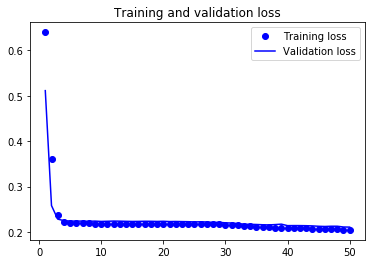

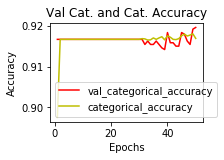

In [31]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score

cv = KFold(n_splits=5,shuffle=True)
results = []
y_pred_list = []

count = 1
for traincv, testcv in cv.split(X):
    print("\n--------Fold {}--------\n".format(count))
    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
    
    train_essays = X_train['essay']
    test_essays = X_test['essay']
    
    sentences = []
    
    for essay in train_essays:
            # Obtaining all sentences from the training essays.
            sentences += essay_to_sentences(essay, remove_stopwords = True)
            
    # Initializing variables for word2vec model.
    num_features = 300 
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3

    print("Training Word2Vec Model...")
    model = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,
                     window = context, sample = downsampling)
    
    model.init_sims(replace=True)
    model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

    clean_train_essays = []
    
    # Generate training and testing data word vectors.
    for essay_v in train_essays:
        clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)
    
    clean_test_essays = []
    for essay_v in test_essays:
        clean_test_essays.append(essay_to_wordlist( essay_v, remove_stopwords=True ))
    testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )
    

    trainDataVecs = np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    # Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    validsiz=200;
    
    y_train = y_train -1
    y_test = y_test-1
    x_val= testDataVecs[0:validsiz]
    y_val = y_test[0:validsiz]
    y_val = to_categorical(y_val, num_classes=12)    
    y_train = to_categorical(y_train, num_classes=12)

    lstm_model = get_model()
    #,validation_data=(x_val, y_val)
    history = lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=50,validation_data=(x_val, y_val))
    y_pred = lstm_model.predict(testDataVecs)
    # Save any one of the 8 models.
    if count == 1:
         lstm_model.save('final_lstm.h5')
    
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)
    '''
    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)
    '''
    
    import matplotlib.pyplot as plt
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


    plt.subplot(222)
    valacc = history.history['val_acc']
    acc = history.history['acc']
    plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
    plt.plot(epochs, acc, 'y', label='categorical_accuracy')
    plt.title('Val Cat. and Cat. Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    break
    count += 1


In [29]:
model = keras.models.load_model("final_lstm.h5")  # Load Keras model we learned using KerasPractice 
test = trainDataVecs[1:2]
test_p = y_train[1:2]
print(test_p)
model.predict(test)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


array([[0.00046757, 0.0006997 , 0.00034589, 0.0022057 , 0.00314459,
        0.02707902, 0.03906158, 0.30294615, 0.23867758, 0.26131994,
        0.07809627, 0.0254368 ]], dtype=float32)